In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [4]:
os.getcwd()

'e:\\projects\\modeling_medical_insurance'

In [3]:
os.chdir("../")

## Reading and Inspecting the Data.

In [5]:
def wrangle(filepath):

    # reading data into a dataframe.
    df=pd.read_csv(filepath)

    # dropping duplicate values
    df.drop_duplicates(inplace=True)

    # setting feature values for consistency
    for feature in ["smoker", "diabetes", "regular_ex"]:
        feature_dict = {
            0:"no",
            1:"yes"
                }
        df[feature].replace(feature_dict, inplace=True)
        df[feature].astype("object")
        
    df.to_csv("artifact/data_ingestion/healthinsurance_clean.csv", index=False, header=True)

    return df

In [6]:
df=wrangle(r"artifact\data_ingestion\1651277648862_healthinsurance.csv")
print(df.shape)
print(df.info())
df.head()

(13904, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 13904 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  13543 non-null  float64
 1   sex                  13904 non-null  object 
 2   weight               13904 non-null  int64  
 3   bmi                  13003 non-null  float64
 4   hereditary_diseases  13904 non-null  object 
 5   no_of_dependents     13904 non-null  int64  
 6   smoker               13904 non-null  object 
 7   city                 13904 non-null  object 
 8   bloodpressure        13904 non-null  int64  
 9   diabetes             13904 non-null  object 
 10  regular_ex           13904 non-null  object 
 11  job_title            13904 non-null  object 
 12  claim                13904 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 1.5+ MB
None


,age,sex,weight,bmi,hereditary_diseases,no_of_dependents,smoker,city,bloodpressure,diabetes,regular_ex,job_title,claim
0,60.0,male,64,24.3,NoDisease,1,no,NewYork,72,no,no,Actor,13112.6
1,49.0,female,75,22.6,NoDisease,1,no,Boston,78,yes,yes,Engineer,9567.0
2,32.0,female,64,17.8,Epilepsy,2,yes,Phildelphia,88,yes,yes,Academician,32734.2
3,61.0,female,53,36.4,NoDisease,1,yes,Pittsburg,72,yes,no,Chef,48517.6
4,19.0,female,50,20.6,NoDisease,0,no,Buffalo,82,yes,no,HomeMakers,1731.7


In [6]:
print(f"After dropping duplicates values, the dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

After dropping duplicates values, the dataset has 13904 rows and 13 columns.


#### Null and Duplicates values

In [6]:
df.duplicated().sum()

np.int64(0)

The dataset had 1096 duplicates values. They have been dropped.

In [14]:
df.isna().sum() /len(df) * 100

age                    2.596375
sex                    0.000000
weight                 0.000000
bmi                    6.480150
hereditary_diseases    0.000000
no_of_dependents       0.000000
smoker                 0.000000
city                   0.000000
bloodpressure          0.000000
diabetes               0.000000
regular_ex             0.000000
job_title              0.000000
claim                  0.000000
dtype: float64

The fraction of missing values is not big considering the size of the dataset itself. I will impute it.

#### Looking at Columns datatypes.

In [11]:
df.dtypes

age                    float64
sex                     object
weight                   int64
bmi                    float64
hereditary_diseases     object
no_of_dependents         int64
smoker                  object
city                    object
bloodpressure            int64
diabetes                object
regular_ex              object
job_title               object
claim                  float64
dtype: object

In [12]:
# number unique values per feature
for col in df.select_dtypes("number"):
    print(col)

age
weight
bmi
no_of_dependents
bloodpressure
claim


In [43]:
# number unique values per feature
for col in df.select_dtypes("object"):
    print(f"{col}: {df[col].nunique()}")

sex: 2
hereditary_diseases: 10
smoker: 2
city: 91
diabetes: 2
regular_ex: 2
job_title: 35


In [44]:
#  unique values per object feature column
for feature in df.columns:
    if df[feature].dtype=="object":
        print(f"{feature} : {df[feature].unique()}\n") 

sex : ['male' 'female']

hereditary_diseases : ['NoDisease' 'Epilepsy' 'EyeDisease' 'Alzheimer' 'Arthritis'
 'HeartDisease' 'Diabetes' 'Cancer' 'High BP' 'Obesity']

smoker : ['no' 'yes']

city : ['NewYork' 'Boston' 'Phildelphia' 'Pittsburg' 'Buffalo' 'AtlanticCity'
 'Portland' 'Cambridge' 'Hartford' 'Springfield' 'Syracuse' 'Baltimore'
 'York' 'Trenton' 'Warwick' 'WashingtonDC' 'Providence' 'Harrisburg'
 'Newport' 'Stamford' 'Worcester' 'Atlanta' 'Brimingham' 'Charleston'
 'Charlotte' 'Louisville' 'Memphis' 'Nashville' 'NewOrleans' 'Raleigh'
 'Houston' 'Georgia' 'Oklahoma' 'Orlando' 'Macon' 'Huntsville' 'Knoxville'
 'Florence' 'Miami' 'Tampa' 'PanamaCity' 'Kingsport' 'Marshall' 'Mandan'
 'Waterloo' 'IowaCity' 'Columbia' 'Indianapolis' 'Cincinnati'
 'Bloomington' 'Salina' 'KanasCity' 'Brookings' 'Minot' 'Chicago'
 'Lincoln' 'FallsCity' 'GrandForks' 'Fargo' 'Cleveland' 'Canton'
 'Columbus' 'Rochester' 'Minneapolis' 'JeffersonCity' 'Escabana'
 'Youngstown' 'SantaRosa' 'Eureka' 'SanFranci

I mapped values for smoker, bloodpressure, diabetes to categorical values and convert the data types to a correct datatypes, objects.The other variables are of correct datatypes.

## Exploratory Data Analysis

#### Numerical Values

Performing basic statistics to check the distribution of the numerical features.

I am temporarily filling the missing values.

In [7]:
df["age"]=df["age"].fillna(df["age"].mean())
df["bmi"]=df["bmi"].fillna(df["bmi"].mean())
# df.isnull().sum()

In [9]:
numeric_features = [col for col in df.columns if df[col].dtype !="object"]
numeric_features.remove("claim")
df[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,13904.0,39.556598,13.827948,18.0,27.0,40.0,51.0,64.0
weight,13904.0,64.894347,13.675070,34.0,54.0,63.0,76.0,95.0
bmi,13904.0,30.273483,5.923446,16.0,25.9,29.9,34.1,53.1
no_of_dependents,13904.0,1.126438,1.225661,0.0,0.0,1.0,2.0,5.0
bloodpressure,13904.0,68.657652,19.430514,0.0,64.0,71.0,80.0,122.0


In [10]:
for col in numeric_features:
    print(f"skewness of {col}:{skew(df[col])}")
    print(f"Kurtosis of {col}:{kurtosis(df[col])}\n")

skewness of age:0.006189387511086038
Kurtosis of age:-1.2014759745573922

skewness of weight:0.2866980421617865
Kurtosis of weight:-0.8621804073036565

skewness of bmi:0.3902819806439793
Kurtosis of bmi:0.12568423046368782

skewness of no_of_dependents:0.9314678868034075
Kurtosis of no_of_dependents:0.20407222203226416

skewness of bloodpressure:-1.9695854467075518
Kurtosis of bloodpressure:5.429872776865185



Most of the variables seems for have a flat distribution with only a bloodpressure variable that seems to have a very high kurtosis.

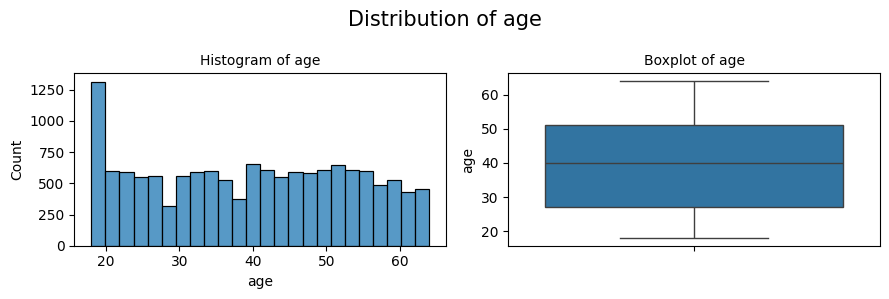

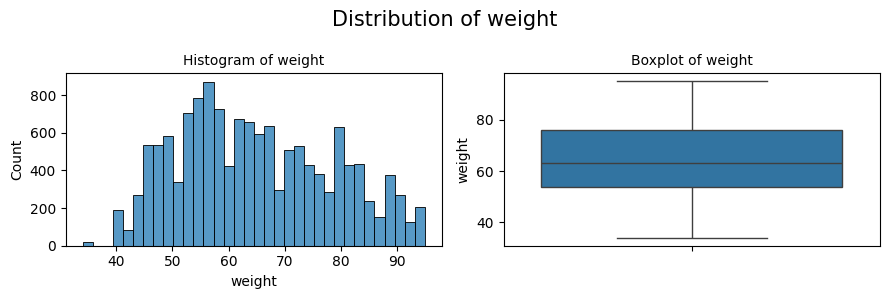

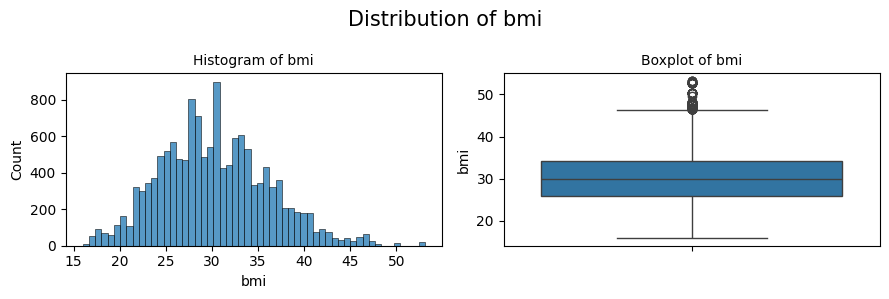

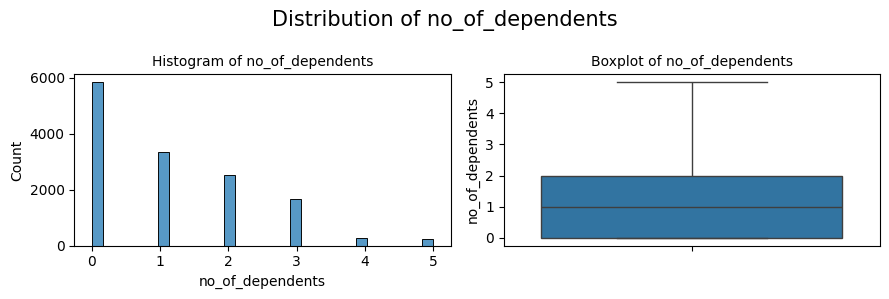

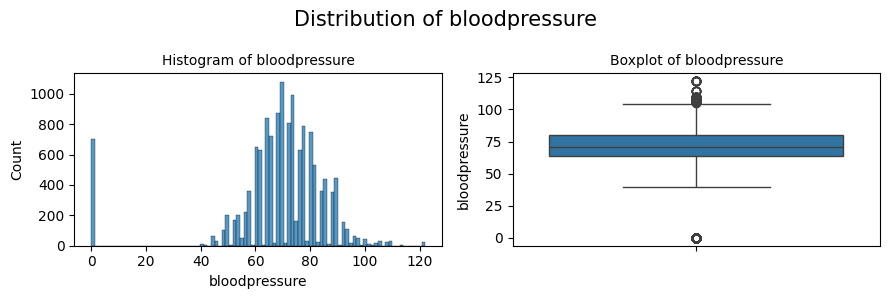

In [31]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 3))

    ax1 = sns.histplot(df[numeric_features[i]], ax=ax1)
    ax1.set_title('Histogram of '+ str(numeric_features[i]), fontsize=10)

    ax2 =sns.boxplot(df[numeric_features[i]], ax=ax2)
    ax2.set_title('Boxplot of '+ str(numeric_features[i]), fontsize=10)

    plt.suptitle('Distribution of '+ str(numeric_features[i]), fontsize=15)
    plt.tight_layout()

* About 75% of customers in this dataset are younger than the  of 50 with the maximum age of 64 with the youngest customer being 18 years old and the oldest is 64 years old. 

* While the maximum number of dependents on these dataset is 5 Less than 75% of customers have 2 or less dependents.

The distribution of age variable seems uniformly distributed with a high frequency at around the ages of 20. This seems odd as most young adult don't pay much attention to health insurances as they believe to have a perception that they are healthier around this age.

The overall distribution of these variables seems to be fairly symmetric with the bmi and bloodpressure variables being slightly skewed. I am not going to transform the distribution of these variables.


#### Categorical Variables

In [11]:
categorical_features = [col for col in df.columns if df[col].dtype =="object"]
df[categorical_features].describe(include='object').T

,count,unique,top,freq
sex,13904,2,female,7091
hereditary_diseases,13904,10,NoDisease,12965
smoker,13904,2,no,11114
city,13904,91,Nashville,270
diabetes,13904,2,yes,10722
regular_ex,13904,2,no,10696
job_title,13904,35,Student,1220


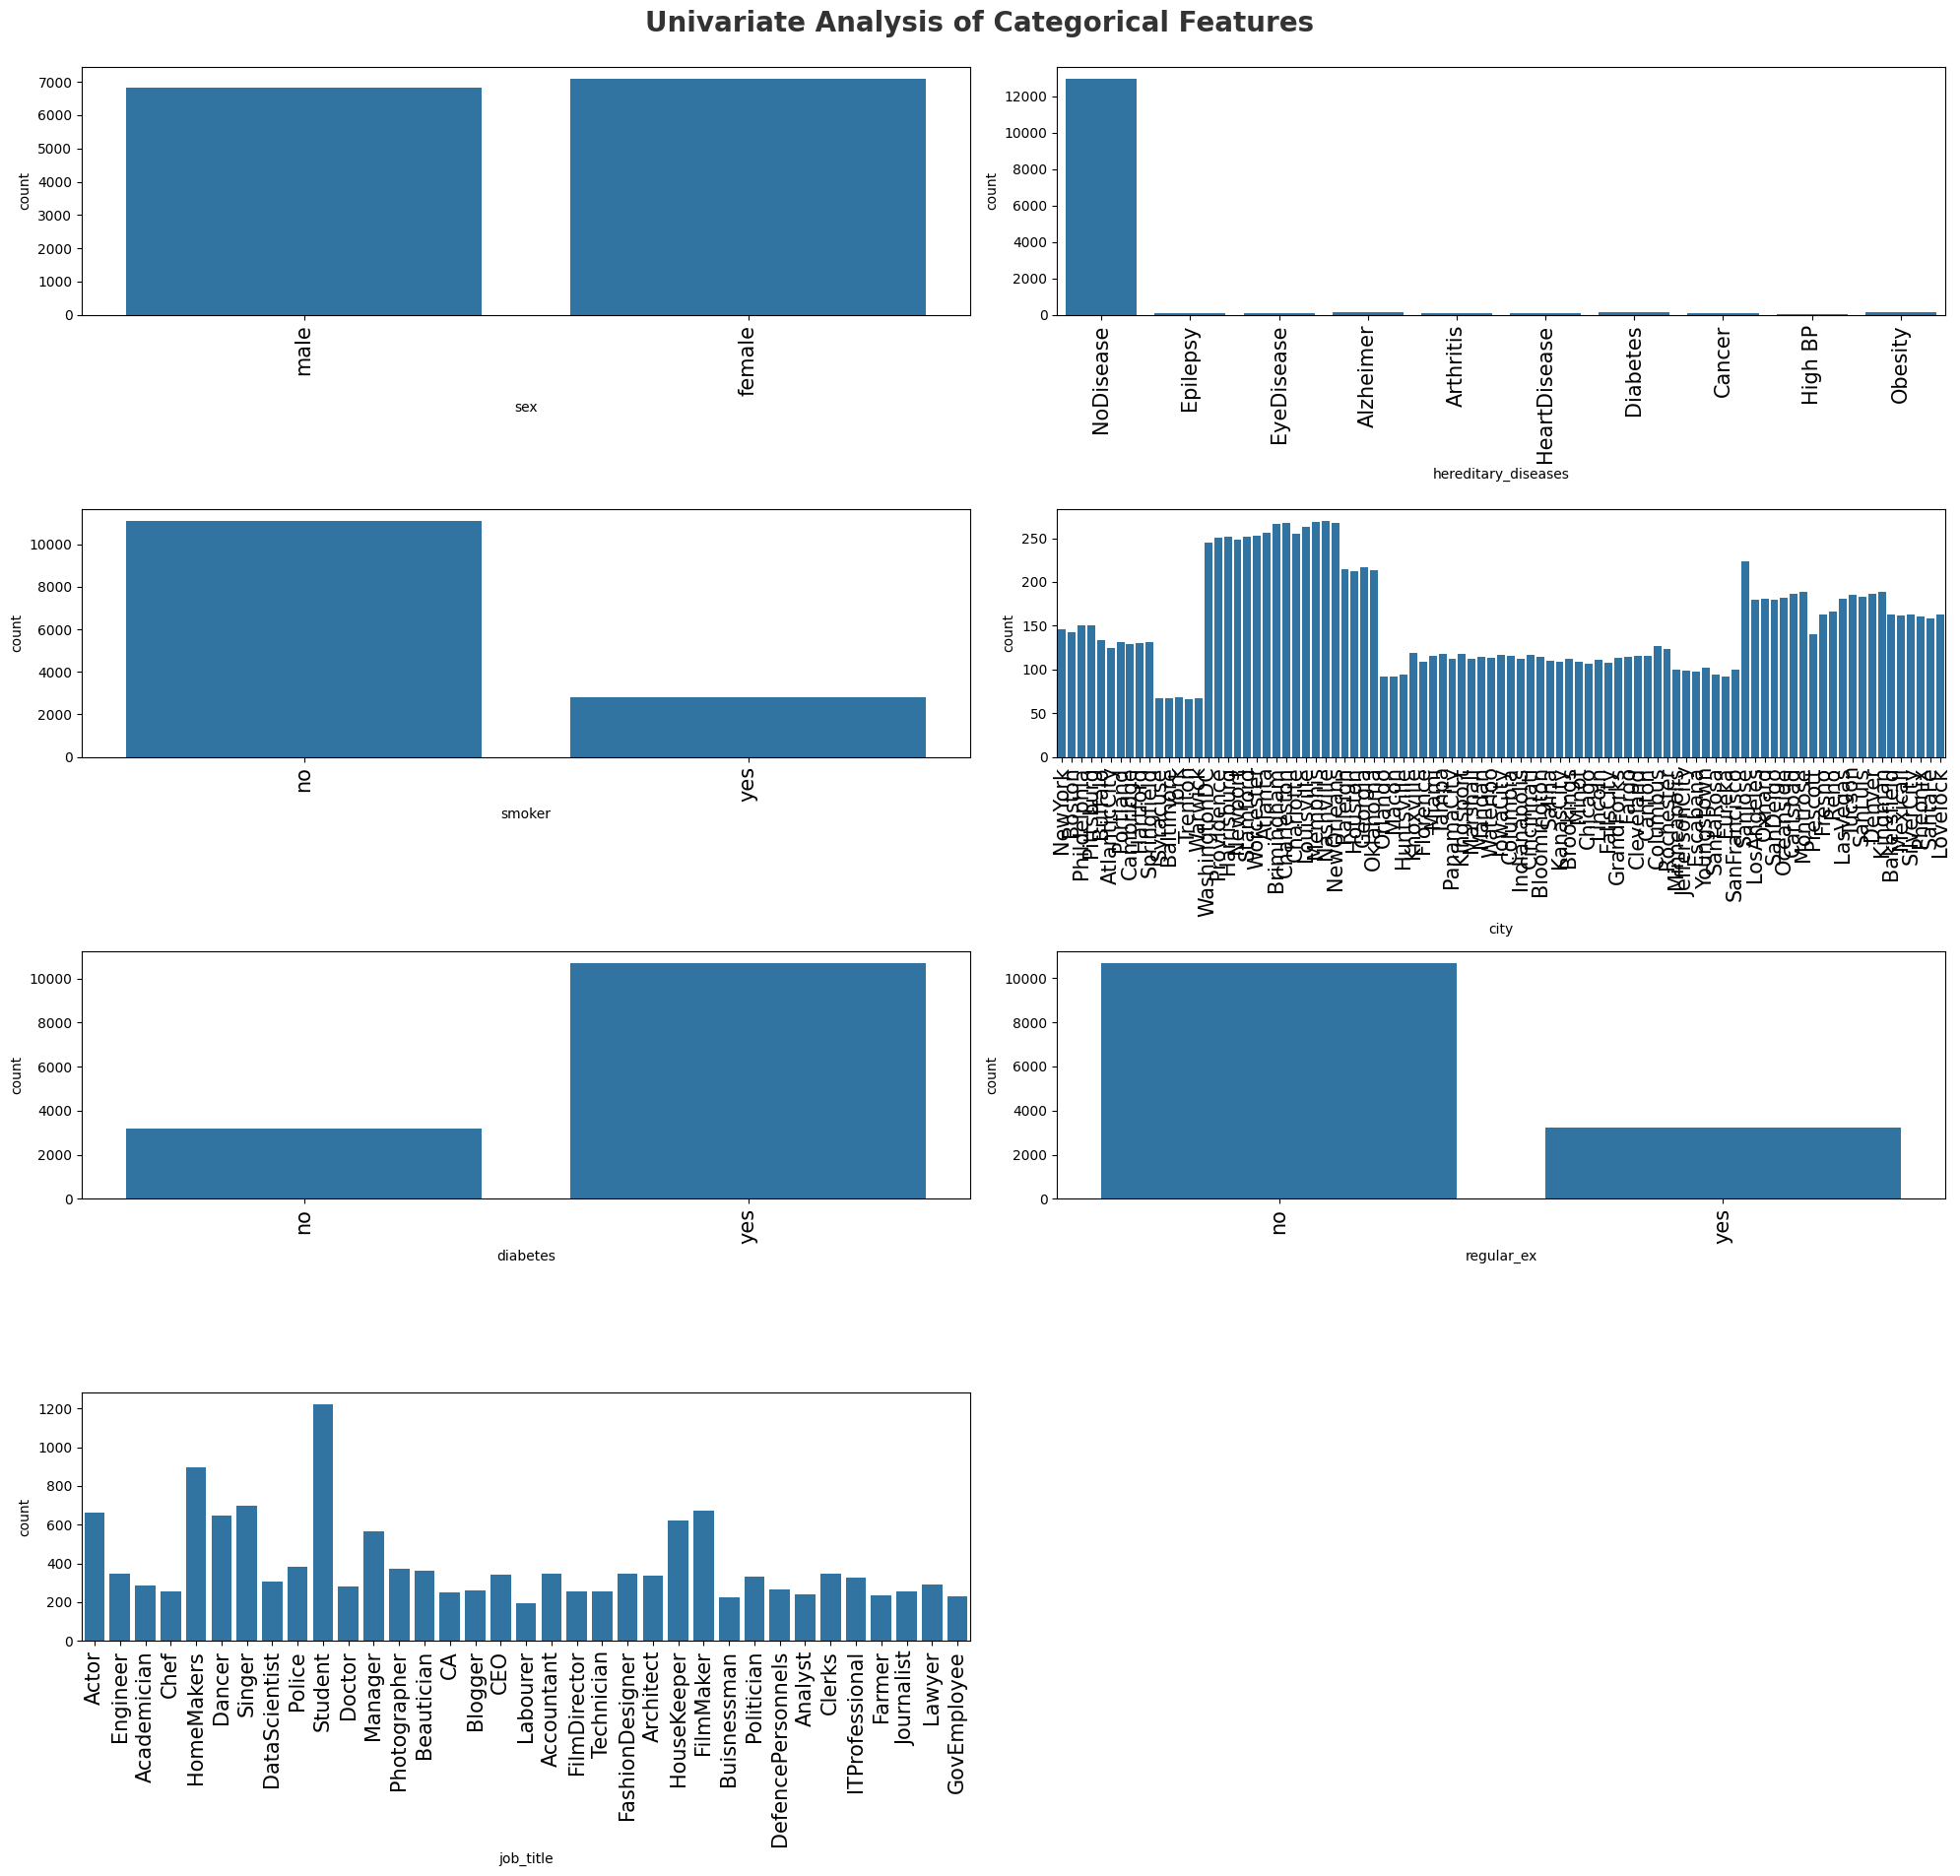

In [66]:
plt.figure(figsize=(20, 19))
plt.suptitle("Univariate Analysis of Categorical Features", fontsize=20, fontweight='bold', alpha=0.8, y=1)
for i in range(0, len(categorical_features)):
    plt.subplot(4,2,i+1)
    ax=sns.countplot(x=df[categorical_features[i]])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
    plt.tight_layout()
    

* Most of the customers are female. 
* Most of the customers don't smoke.
* Most of the customers do not excesize regulary 

According to the diabetes feature, more 10 000 customers are diabetes. While the hereditary_disease variable says less 2000 customers in this dataset are diabetes. 

### Correlation Between Variables

Text(0.5, 1.0, 'Correlation Heatmap')

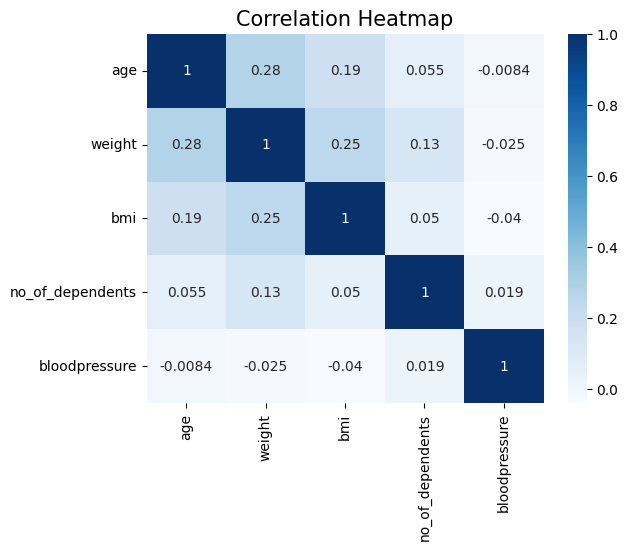

In [7]:
numeric_features = [col for col in df.columns if df[col].dtype !="object"]
numeric_features.remove("claim")
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap", fontsize=15)

There is no correlation between numerical variables.

### Claim vs other variable

Adding a new column to the dataset called age_group.

In [72]:
age_bins=[18, 30, 42, 54, 66]
age_labels = [f"{i}-{i+12}" for i in range(18, 66, 12)]
df["age_group"] = pd.cut(df['age'], bins=age_bins, labels= age_labels, right=False)

In [86]:
print(f"Insurance Claim: average value {df['claim'].mean()}")

Insurance Claim: average value 13431.813744246261


In [83]:
sex_pivot=pd.pivot_table(data=df, index='sex', values='claim',aggfunc=np.mean).sort_values(by='claim')
sex_pivot

,claim
sex,
female,12748.322000
male,14143.194921


The average claim for male is higher the average claim for female.

In [88]:
sex_pivot=pd.pivot_table(data=df, index='no_of_dependents', values='claim',aggfunc=np.mean).sort_values(by='claim')
sex_pivot.reset_index()

,no_of_dependents,claim
0,5,8388.596875
1,0,12364.585626
2,1,13139.266815
3,4,13862.855882
4,2,15229.200198
5,3,15627.621275


<Figure size 1200x600 with 0 Axes>

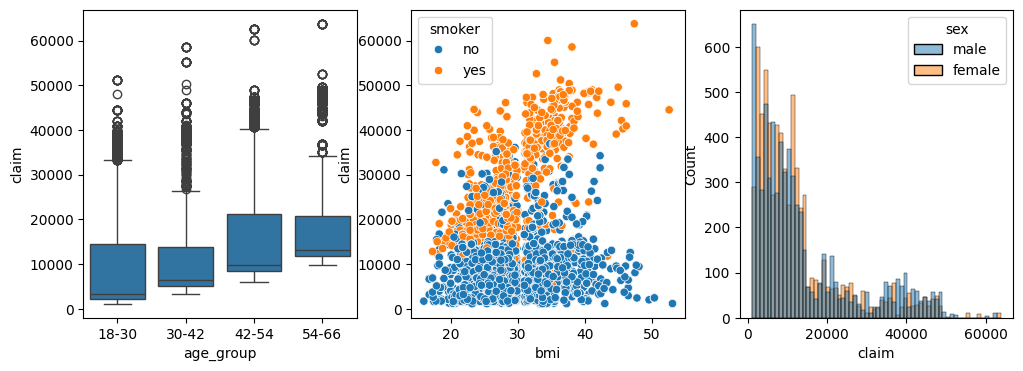

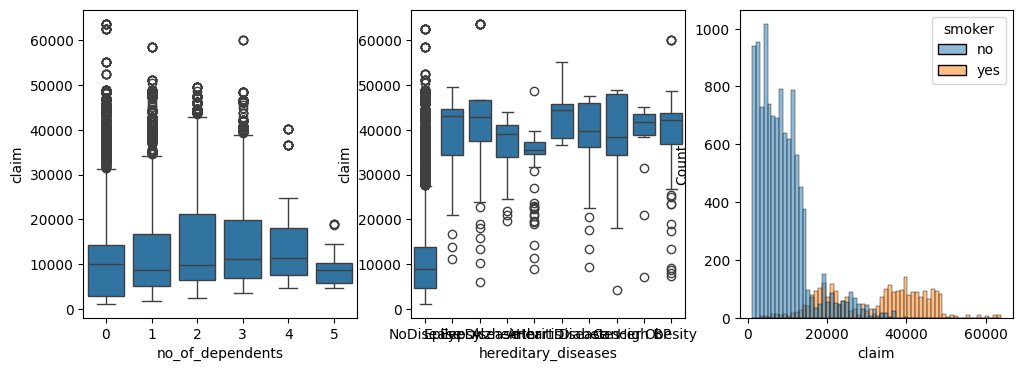

In [82]:
fig = plt.figure(figsize=(12,6))
(topfig, bottomfig) =fig.subfigures(2,1)
# topfig.subplots_adjust(left = .1)
fig, (ax1, ax2, ax3) =plt.subplots(ncols=3, figsize=(12,4))
ax1 =sns.boxplot(df, y="claim", x="age_group", ax=ax1)
ax2 = sns.scatterplot(df, y="claim", x="bmi", hue="smoker", ax=ax2)
ax3 = sns.histplot(df, x="claim", hue="sex", ax=ax3)

fig, (ax1, ax2, ax3) =plt.subplots(ncols=3, figsize=(12,4))
ax1 =sns.boxplot(df, y="claim", x="no_of_dependents", ax=ax1)
ax2 = sns.boxplot(df, y="claim", x="hereditary_diseases", ax=ax2)
ax3 = sns.histplot(df, x="claim", hue="smoker", ax=ax3)